In [5]:
import tensorflow as tf
from tensorflow import keras
import cv2
import csv
import numpy as np
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Convolution2D, MaxPooling2D, Activation, concatenate, Dropout
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, Dense, Lambda, Flatten
from tensorflow.keras.models import Model, load_model
from matplotlib import pyplot as plt
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import SGD, Adam
import tensorflow_probability as tfp
tfd=tfp.distributions
tfpl=tfp.layers
from tensorflow import math
from tensorflow import random
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Load Data**

In [3]:
def read_data(path):

    #open path to read dataset.csv
    csvFile = open(path, "r")
    reader = csv.reader(csvFile)
    #assgin array to load two images and labels
    frame_0 = []
    frame_1 = []
    label = []

    for item in reader:   
    #read frames' path and labels
        frame_0_temp = item[0]
        frame_1_temp = item[1]
        label_temp = item[2]
        label_temp = float(label_temp)  
    #load frame through the frame path
        img0 = cv2.imread(frame_0_temp)
        img1 = cv2.imread(frame_1_temp)
    # use "append" to load images to array
        frame_0.append(img0)
        frame_1.append(img1)
        label.append(label_temp)
    #print('read data part: ',label)
    return frame_0, frame_1, label

def process_data(f0,f1,lab):

  #lab=keras.utils.to_categorical(lab, 1)
  
  f0 = np.asarray(f0)
  f1 = np.asarray(f1)
  lab = np.asarray(lab)
  #print(lab)
  
  return f0,f1,lab

In [4]:
training_path = '/content/drive/MyDrive/Daming Colab/Ranking/train_data_set_12000.csv'
validation_path = '/content/drive/MyDrive/Daming Colab/Ranking/train_data_set_8000.csv'

frame_0_train, frame_1_train, label_train = read_data(training_path)
frame_0_val, frame_1_val, label_val = read_data(validation_path)

frame_0_train, frame_1_train, label_train = process_data(frame_0_train, frame_1_train, label_train)
frame_0_val, frame_1_val, label_val = process_data(frame_0_val, frame_1_val, label_val)

print("finish loading DATA !")

finish loading DATA !


# **Custom Functions**

In [6]:
# define activation func for stddev
# call while load model
def custom_activation(x):
    return tf.nn.elu(x) + 1 

In [7]:
def layer(mu,std):

  mu=mu
  #stddev = tf.math.exp(logvar*0.5)
  esp = np.random.randn()
  sample = mu + std*esp

  return sample

# **FireModule For SqueezeNet**

In [8]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    s_id = 'fire' + str(fire_id) + '/'

    if K.image_data_format() == 'channels_first':
        channel_axis = 1
    else:
        channel_axis = 3
    
    x = Convolution2D(squeeze, (1, 1), padding='valid', name=s_id + 'sq1x1')(x)
    x = Activation('relu', name=s_id + 'relu' + 'sq1x1')(x)

    left = Convolution2D(expand, (1, 1), padding='valid', name=s_id + 'exp1x1')(x)
    left = Activation('relu', name=s_id + 'relu' + 'exp1x1')(left)

    right = Convolution2D(expand, (3, 3), padding='same', name=s_id + 'exp3x3')(x)
    right = Activation('relu', name=s_id + 'relu' + 'exp3x3')(right)

    x = concatenate([left, right], axis=channel_axis, name=s_id + 'concat')
    return x

## SqueezeNet with **Dist**

In [9]:
def SqueezeNet_ND():
    
    input_tensor = Input(shape=(224, 224, 3))
    input_frame = Input(shape=(224, 224, 3))

    x = Convolution2D(64, (3, 3), strides=(2, 2), padding='valid', name='conv1')(input_frame)
    x = Activation('relu', name='relu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=16, expand=64)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool3')(x)

    x = fire_module(x, fire_id=4, squeeze=32, expand=128)
    x = fire_module(x, fire_id=5, squeeze=32, expand=128)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool5')(x)

    x = fire_module(x, fire_id=6, squeeze=48, expand=192)
    x = fire_module(x, fire_id=7, squeeze=48, expand=192)
    x = fire_module(x, fire_id=8, squeeze=64, expand=256)
    x = fire_module(x, fire_id=9, squeeze=64, expand=256)

    #x = GlobalMaxPooling2D()(x)
    # regular squeezenet model end here

    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)

    mu = Dense(1)(x)
    std = Dense(1,activation='custom_activation')(x)
    #mu,logvar = tf.split(x,2) # split the 'score' to mean and stddev 

    # X ~ Normal(loc=mu, scale=sigma)
    # where loc = mu is the mean, scale = sigma is the std. deviation

    sample = layer(mu=mu,std=std,in_size=1,out_size=1)

    print(sample.shape)
    model = Model(input_frame,[sample,mu,std])

    return model
  

model_ND = SqueezeNet_ND()
model_ND.summary()
plot_model(model_ND, to_file='model_ND.png', show_shapes=True, show_layer_names=True)

ValueError: ignored

## @@@

In [ ]:
    # some things that have been tried......
    '''
    #both mean and var are trainable
    x = Dense(1+1, activation="relu")(x)
    x=tfpl.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[...,:1], scale=tf.math.softplus(t[...,1:]))))(x)
    '''
    '''
    #with IndependentNormal
    event_shape=1
    x=Dense(units=tfpl.IndependentNormal.params_size(event_shape),input_shape=(128,))(x)
    x=tfpl.IndependentNormal(event_shape)(x)
    model = Model(input_frame,x)
    #model = Model(inputs=input_frame,outputs=[mu,sigma])
    return model
    '''

    '''
    # MDN 
    mu = Dense(1,activation='linear')(x)                      
    sigma = Dense(units=1, activation=custom_activation)(x)
    '''
dist = tfpl.DistributionLambda(lambda t : tfd.Normal(
                              loc=t[0],scale=tf.math.softplus(t[1])),
                              # softplus(x) = log(exp(x) + 1) ensure std dec positive
                              convert_to_tensor_fn=lambda s: s.sample(4))(mu,sigma)
                              # output s distribution samples 

# **Siamese**

(None, 2)
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
input_8 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
model (Functional)              [(None, 1), (None, 1 11798466    input_7[0][0]                    
                                                                 input_8[0][0]                    
__________________________________________________________________________________________________
tf.math.subtract_1 (TFOpLambda) (None, 1)            0           model[2][0]      

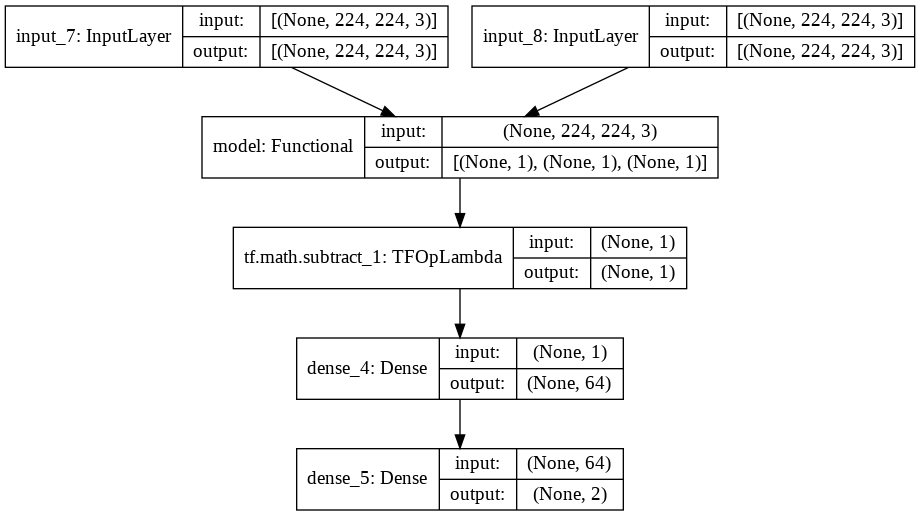

In [ ]:
def siamese():
  
    input_tensor = Input(shape=(224, 224, 3))

    input_frame_1 = Input(shape=(224, 224, 3))
    input_frame_2 = Input(shape=(224, 224, 3))
    
    [sample1,mu1,stddev1] = model_ND(input_frame_1)
    [sample2,mu2,stddev2] = model_ND(input_frame_2)                  

    diff = Dense(64, activation='relu')(sample1-sample2)
    score = Dense(2, activation='sigmoid')(diff)

    print(score.shape)

    siamese_model = Model(inputs=[input_frame_1, input_frame_2], outputs=score)

    return siamese_model

siamese_model=siamese()
siamese_model.summary()
plot_model(siamese_model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
siamese_model.compile(keras.optimizers.SGD(learning_rate=1e-3),
                      loss=keras.losses.binary_crossentropy,
                      metrics=['accuracy'])

history=siamese_model.fit([frame_0_train, frame_1_train], label_train, 
                      epochs=10, batch_size=10, 
                      validation_data=([frame_0_val, frame_1_val], label_val), 
                      shuffle=True,
                      verbose=1)

Epoch 1/10
803/803 [==============================] - 31s 33ms/step - loss: 0.6840 - accuracy: 0.8786 - val_loss: 0.6709 - val_accuracy: 0.9293
Epoch 2/10
803/803 [==============================] - 26s 32ms/step - loss: 0.5192 - accuracy: 0.8657 - val_loss: 0.1204 - val_accuracy: 0.9570
Epoch 3/10
803/803 [==============================] - 26s 33ms/step - loss: 0.0874 - accuracy: 0.9639 - val_loss: 0.0739 - val_accuracy: 0.9660
Epoch 4/10
803/803 [==============================] - 26s 32ms/step - loss: 0.0741 - accuracy: 0.9661 - val_loss: 0.0696 - val_accuracy: 0.9670
Epoch 5/10
803/803 [==============================] - 26s 32ms/step - loss: 0.0694 - accuracy: 0.9673 - val_loss: 0.0679 - val_accuracy: 0.9680
Epoch 6/10
803/803 [==============================] - 25s 32ms/step - loss: 0.0672 - accuracy: 0.9682 - val_loss: 0.0662 - val_accuracy: 0.9663
Epoch 7/10
803/803 [==============================] - 26s 32ms/step - loss: 0.0647 - accuracy: 0.9681 - val_loss: 0.0645 - val_accuracy:

# **Plot&Save**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


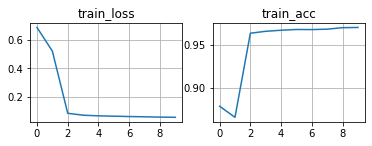

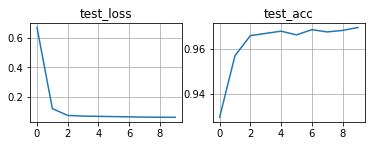

In [ ]:
print(history.history.keys())
plt.subplot(221)
plt.plot(history.history["loss"])
plt.grid()
plt.title("train_loss")

plt.subplot(222)
plt.plot(history.history["accuracy"])
plt.grid()
plt.title("train_acc")
plt.show()

plt.subplot(221)
plt.plot(history.history["val_loss"])
plt.grid()
plt.title("test_loss")

plt.subplot(222)
plt.plot(history.history["val_accuracy"])
plt.grid()
plt.title("test_acc")
plt.show()

In [ ]:
model_ND.save('/content/drive/MyDrive/Daming Colab/Ranking/Model/Ranking_Model_0308.h5')